# Dealing with Bias and Fairness in Data Science Systems
## KDD 2020 Hands-on Tutorial
### Pedro Saleiro, Kit Rodolfa, Rayid Ghani

# <font color=red>Exploring Bias Reduction Strategies</font>

## 1. Install dependencies, import packages and data
This is needed every time you open this notebook in **colab** to install dependencies

In [1]:
!pip install aequitas
!pip install fairlearn
import yaml
import os
import pandas as pd
import numpy as np
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import fairlearn
sns.set() 
DPI = 200
DATAPATH = 'https://github.com/dssg/fairness_tutorial/raw/master/data/'

     |████████████████████████████████| 2.2MB 1.4MB/s 
     |████████████████████████████████| 92kB 6.5MB/s 
     |████████████████████████████████| 102kB 5.6MB/s 
     |████████████████████████████████| 276kB 9.4MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 163kB 11.2MB/s 
     |████████████████████████████████| 460kB 11.1MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 2.6MB 12.6MB/s 
  Created wheel for millify: filename=millify-0.1.1-cp36-none-any.whl size=1867 sha256=5f29537c645d800a5704fe28b1d34c99a3679e0711bfdc4ba9ac47ee495aff3c
  Stored in directory: /root/.cache/pip/wheels/19/7d/d9/3f1ca52c5b6c4f05b11f1ab5a088fc1cf6174965e81308faeb
  Created wheel for xhtml2pdf: filename=xhtml2pdf-0.2.2-cp36-none-any.whl size=231059 sha256=4057518f2db86415189af24055c92ae8e16ab04d40f895aa67530f6b0f07b5a3
  Stored in directory: /root/.cache/pip/wheels/37/e9/d9/8ef244092a2b3b004ab197f5c707973c

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. 

As described earlier, the goal here is to select top 1000 project submissions that are likely to not get funded in order to prioritize resource allocation. That corresponds to the metric **Preicision at top 1000**.

### <font color=red>We audited the "best" model at precision at top 1000 and found that it has disparities for True Positive Rate for all attributes that we care about (poverty_level of the school, sex, and school_location_type)</font>


## What do we want to do now?

1. Could we have picked a different model that was similar enough in "precision at top 1000" but less biased?


## Load predictions, labels, and attributes for all models that were built to audit

In [2]:
evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')
evals_df.head(10)

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid,target_pp,matrix_type,matrix_start_date,matrix_end_date
0,0.552,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,test,2012-12-01,2013-01-31
1,0.551,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,test,2012-12-01,2013-01-31
2,0.550,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",8823d053f9fbe6c34efdae3a2f24c39c,5e78e49f70fac0193eaadb8513428f23,1000,test,2012-12-01,2013-01-31
3,0.549,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 2, ""num_leaves"": 5...",ffc7abef4fe933b0f0cfed63d5d03910,f04edad1446642411085e84271898506,1000,test,2012-12-01,2013-01-31
4,0.548,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",110d892ce37127a79d7c6e0eac9a5d13,09092f371176a13cddca59bac20da4fd,1000,test,2012-12-01,2013-01-31
5,0.547,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""entropy"", ""max_de...",856a91cee8d3e81d35b0c7578d8459cb,dc9f61602f5c90b70aa8e6040eaf2972,1000,test,2012-12-01,2013-01-31
6,0.544,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",9d582bc500e1d99e0949ec9d35ae8eb3,d3de1db6eed5cfab17d64d6a13e20c8d,1000,test,2012-12-01,2013-01-31
7,0.544,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",bcc12af1a0ae151aabd5238e3a4fb242,eb671681600d5304fce6873004c61c50,1000,test,2012-12-01,2013-01-31
8,0.543,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",7fa15e633491add493d45e9dc7440315,5bd60c3f912e6d62b9acf7b3a56ae803,1000,test,2012-12-01,2013-01-31
9,0.543,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""entropy"", ""max_de...",da8d97ec5529f435974e238b1b29cf7f,4cd560dcb70bfe5bfef3ad1628eaba8a,1000,test,2012-12-01,2013-01-31


### Spot-check the model with highest precision at 1000 to see what type it is

In [3]:
evals_df['hyperparameters'][0]

'{"n_jobs": -1, "criterion": "gini", "max_depth": 30, "max_features": "sqrt", "n_estimators": 87, "random_state": 213500298, "min_samples_leaf": 44, "min_samples_split": 3}'

## Load pre-computed Aequitas audit results 

In [5]:
aequitas_df = pd.read_csv(DATAPATH + 'split2_aequitas.csv.gz', compression='gzip')
aequitas_df.head(10)

,model_uuid,predictions_uuid,k,attribute_name,attribute_value,tpr,tpr_disparity,tpr_ref_group_value,pp,tp,group_label_pos,prev,group_size,matrix_type,matrix_start_date,matrix_end_date
0,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,suburban_rural,0.139156,1.000000,suburban_rural,626,333,2393,0.367814,6506,test,2012-12-01,2013-01-31
1,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,urban,0.042674,0.306665,suburban_rural,192,120,2812,0.308502,9115,test,2012-12-01,2013-01-31
2,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,female,0.102390,3.370670,male,951,527,5147,0.341019,15093,test,2012-12-01,2013-01-31
3,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,lower,0.137859,1.000000,lower,753,394,2858,0.370976,7704,test,2012-12-01,2013-01-31
4,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,highest,0.050771,0.368285,lower,247,158,3112,0.312043,9973,test,2012-12-01,2013-01-31
5,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,male,0.030377,1.000000,male,49,25,823,0.318498,2584,test,2012-12-01,2013-01-31
6,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,lower,0.149405,1.000000,lower,805,427,2858,0.370976,7704,test,2012-12-01,2013-01-31
7,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,highest,0.039846,0.266696,lower,195,124,3112,0.312043,9973,test,2012-12-01,2013-01-31
8,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,female,0.101613,2.986684,male,944,523,5147,0.341019,15093,test,2012-12-01,2013-01-31
9,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,male,0.034022,1.000000,male,56,28,823,0.318498,2584,test,2012-12-01,2013-01-31


This method will help us  plot the 400 models we trained and tested to see what are the current bias-performance tradeoffs

In [6]:
def create_scatter_disparity_performance(evals_df, aequitas_df,  attr_col, group_name, 
                                         performance_col='model_precision', bias_metric='tpr', flip_disparity=False, 
                                         mitigated_tag=None, mitigated_bdf=pd.DataFrame(), mitigated_performance=None, ylim=None):
    disparity_df = aequitas_df.loc[(aequitas_df['attribute_name']==attr_col) & (aequitas_df['attribute_value']==group_name)].copy()
    disparity_metric = bias_metric + '_disparity'
    scatter_schema = ['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric, 'model_tag']
    if flip_disparity:
        disparity_df[disparity_metric]= disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
    scatter = pd.merge(evals_df, disparity_df, how='left', on=['model_uuid'], left_index=True, sort=True, copy=True)
    scatter = scatter[['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric]].copy()
    scatter['model_tag'] = 'Other Models'
    scatter.sort_values('model_precision', ascending = False, inplace=True, ignore_index=True)
    scatter['model_tag'] = scatter.apply(lambda x: 'Highest Precision at 1000' if int(x.name) < 1 else x['model_tag'], axis=1)
    if not mitigated_bdf.empty and mitigated_performance !=None:
      mitigated_bdf[performance_col] = mitigated_performance
      mitigated_bdf['model_tag'] = mitigated_tag
      new_disparity_df = mitigated_bdf.loc[(mitigated_bdf['attribute_name']==attr_col) & (mitigated_bdf['attribute_value']==group_name)].copy()
      if flip_disparity:
        new_disparity_df[disparity_metric]= new_disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
      scatter_new = new_disparity_df[[c for c in new_disparity_df.columns if c in scatter_schema]]
      scatter_final = pd.concat([scatter, scatter_new], axis=0)
    else:
      scatter_final = scatter.copy()
    ax = sns.scatterplot(
        x='model_precision', y=disparity_metric, hue='model_tag',
        data=scatter_final,
        alpha=0.5, s=20,
    )
    if ylim:
        plt.ylim(0, 10)
    flip_placeholder = 'Flipped' if flip_disparity else ''
    ax.set_title('{} {} vs.{} for {}:{}'.format(flip_placeholder, disparity_metric, performance_col, attr_col,group_name ), y=1.)
    plt.gcf().set_size_inches((4, 3))
    plt.legend(loc='upper left', fontsize='xx-small')

    plt.gcf().set_dpi(DPI)
    plt.show() 




## Let's see if we could have picked a better model for fairness in Poverty Level

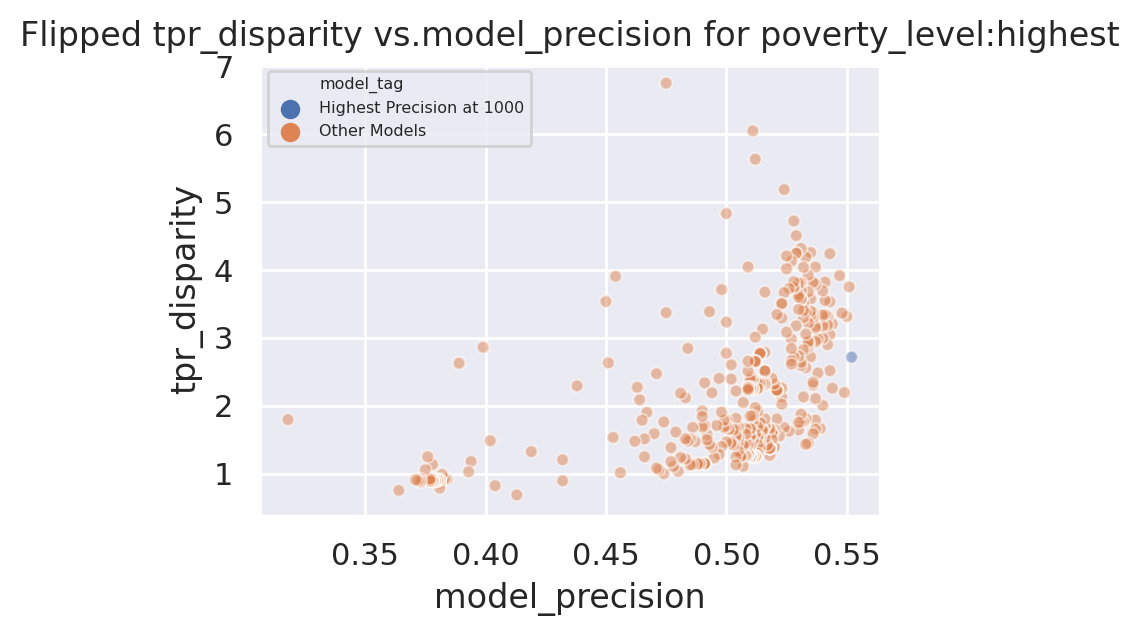

In [7]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'poverty_level', 'highest', flip_disparity=True )

## Let's see if we could have picked a better model for fairness in Metro Type


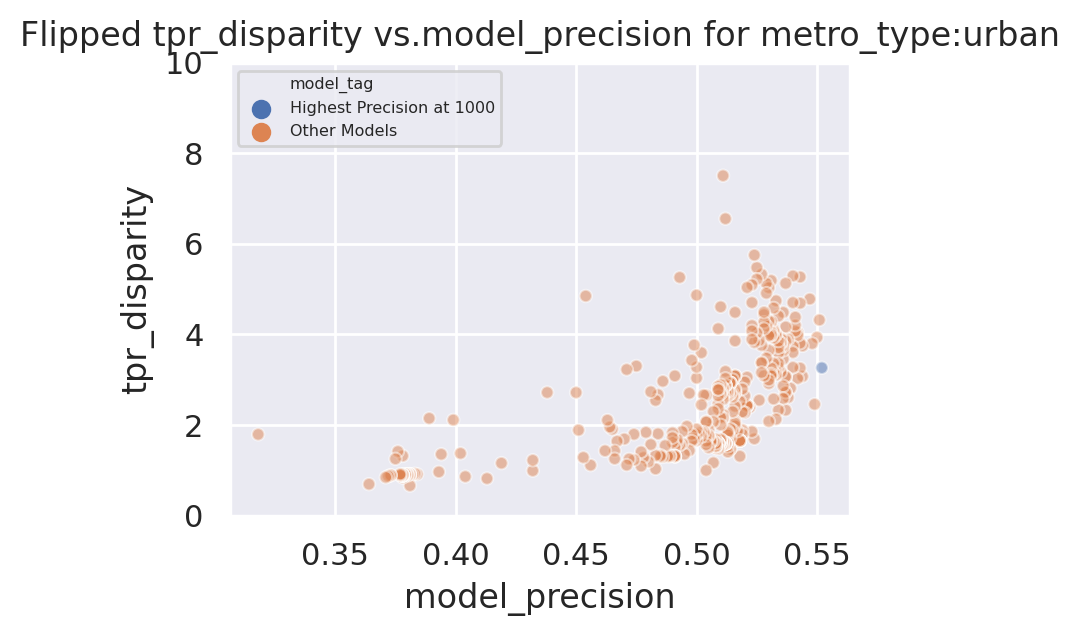

In [8]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'metro_type', 'urban', flip_disparity=True, ylim=10 )

## Let's see if we could have picked a better model for fairness in Teacher sex



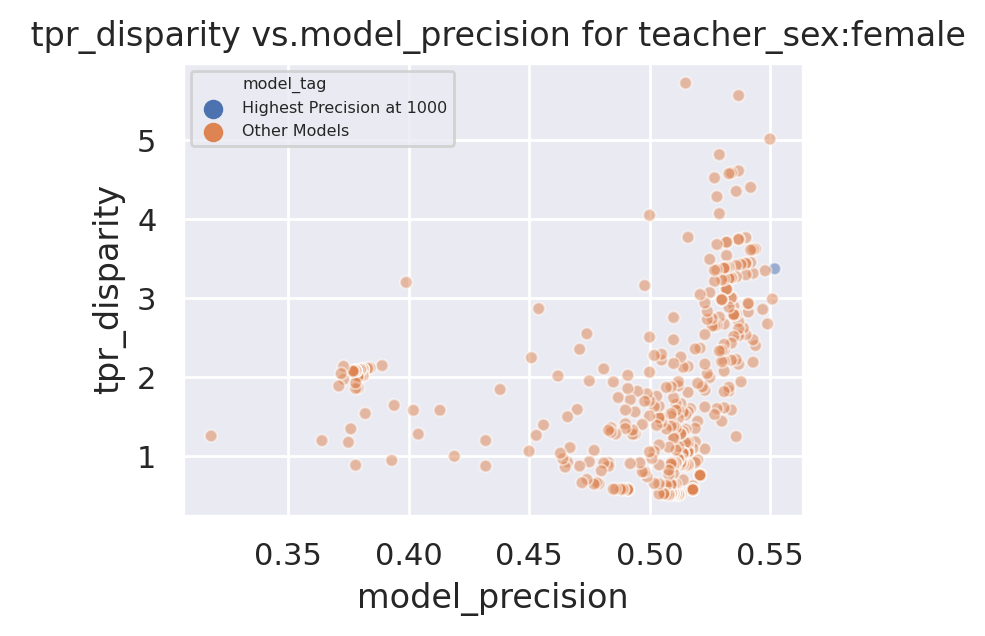

In [9]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'teacher_sex', 'female', flip_disparity=False )

# Bias Reduction Strategies
We will try a few different bias reduction strategies now and compare the audit results with the original models

1. Re-Sampling
2. Regularization (using Fairlearn package)
3. Post-hoc adjustment


## <font color="red">Bias Reduction Strategy 1: Re-Sampling</font>
### Can resampling approaches help improve the fairness of our models?

1. Load data
2. Look at training data distributions
3. Try Resampling in a few different ways
4. Rebuild model(s) on resampled training data
5. Predict on the test set
6. Audit for Bias and Compare

### What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. We then used these results to pick a "best" model in terms of performance on the "accuracy" metric we care about: **Precision at the top 1000** (corresponding to our goal of selecting 1000 project submissions that are most likely to not get funded in order to prioritize resource allocation).

When we audited this selected model with Aequitas, however, we found biases across many attributes, including the poverty level of the schools. Here, we explore a methods based on resampling to reduce this bias in the selected model.

### Load data

In [10]:
traindf = pd.read_csv(DATAPATH + 'train_20120501_20120801.csv.gz', compression='gzip')
testdf = pd.read_csv(DATAPATH + 'test_20121201_20130201.csv.gz', compression='gzip')
train_attrdf = pd.read_csv(DATAPATH + 'train_20120501_20120801_protected.csv.gz', compression='gzip')
test_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')


In [11]:
traindf.shape

(16790, 113)

In [12]:
train_attrdf['poverty_level'].value_counts()

highest    9448
lower      7342
Name: poverty_level, dtype: int64

### Load pre-built models and predictions

In [13]:
evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')

### Take a look at the "Best" performing model

In [14]:
evals_df[evals_df['model_uuid']=='a04e2eedd9c5ff18bcf77e84ae9db561']

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid,target_pp,matrix_type,matrix_start_date,matrix_end_date
0,0.552,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,test,2012-12-01,2013-01-31


In [15]:
import ast
hyperparameters= ast.literal_eval(evals_df['hyperparameters'][0])

In [16]:
rf = RandomForestClassifier(**hyperparameters)

In [17]:
rf.__dict__

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'min_impurity_split',
  'random_state',
  'ccp_alpha'),
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 44,
 'min_samples_split': 3,
 'min_weight_fra

### Look at training data distributions

#### Poverty_level=Highest
label_pos_poverty_highest =  P(poverty_level=highest | not_funded)

label_neg_poverty_highest =  P(poverty_level=highest | funded)


#### Poverty_level=Lower
label_pos_poverty_lower =  P(poverty_level=lower | not_funded)

label_neg_poverty_lower =  P(poverty_level=lower | funded)


In [18]:
label_pos_poverty_highest = traindf.loc[(train_attrdf['poverty_level']=='highest') & (traindf['quickstart_label'] > 0)]
label_neg_poverty_highest = traindf.loc[(train_attrdf['poverty_level']=='highest') & (traindf['quickstart_label'] < 1.0)]

In [19]:
label_pos_poverty_lower = traindf.loc[(train_attrdf['poverty_level']=='lower') & (traindf['quickstart_label'] > 0)]
label_neg_poverty_lower = traindf.loc[(train_attrdf['poverty_level']=='lower') & (traindf['quickstart_label'] <1.0)]

In [20]:
label_pos_poverty_highest.shape

(3196, 113)

In [23]:
label_neg_poverty_highest.shape

(6252, 113)

In [24]:
label_pos_poverty_lower.shape

(3130, 113)

In [ ]:
label_neg_poverty_lower.shape

In [ ]:
print('Highest Poverty training set prevalence:', len(label_pos_poverty_highest) / len(train_attrdf[train_attrdf['poverty_level']=='highest']))

In [26]:
print('Lower Poverty training set prevalence:', len(label_pos_poverty_lower) / len(train_attrdf[train_attrdf['poverty_level']=='lower']))

Lower Poverty training set prevalence: 0.42631435576137294


### What type of disparities do we see in the data distribution here?


1.

2.

3.

4.


















...







### Let's now try resampling

We can perform three types of resampling:

1. Change the training data such that different poverty levels are distributed more uniformly but keep the distribution of labels the same within each poverty level P(poverty_level = highest) = P (poverty_level=lower)


2. Change the training data such that different poverty levels have more uniform label distributions P(poverty_level = highest | not funded ) = P(poverty_level=lower | not funded)


3. Change both


### Approach 2: Change the training data such that different poverty levels have more uniform label distributions 

In [27]:
n_pos_highest = 3150
n_neg_highest = 5000
print('Highest new training prevalence:', n_pos_highest / (n_pos_highest + n_neg_highest))

Highest new training prevalence: 0.38650306748466257


In [28]:
n_pos_lower = 2500
n_neg_lower = 4000
print('Lower new training prevalence:', n_pos_lower / (n_pos_lower + n_neg_lower))

Lower new training prevalence: 0.38461538461538464


In [29]:
sample_pos_poverty_highest = label_pos_poverty_highest.sample(n=n_pos_highest, replace=False)
sample_neg_poverty_highest = label_neg_poverty_highest.sample(n=n_neg_highest, replace=False)

sample_pos_poverty_lower = label_pos_poverty_lower.sample(n=n_pos_lower, replace=False)
sample_neg_poverty_lower = label_neg_poverty_lower.sample(n=n_neg_lower, replace=False)

#### Rebuild model on resampled training data

In [30]:
new_traindf = pd.concat([sample_pos_poverty_highest,sample_neg_poverty_highest,sample_pos_poverty_lower, sample_neg_poverty_lower], axis=0)
y_train = new_traindf['quickstart_label'].values
rf.fit(new_traindf.drop(['entity_id','as_of_date','quickstart_label'], axis = 1), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=44, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=87, n_jobs=-1,
                       oob_score=False, random_state=213500298, verbose=0,
                       warm_start=False)

#### Predict on the test set and calculate precision at 1000

In [31]:
y_pred = rf.predict_proba(testdf.drop(['entity_id','as_of_date','quickstart_label'], axis = 1))[:,1]
new_preds = testdf[['entity_id','as_of_date','quickstart_label']].copy()
new_preds['predict_proba'] = y_pred
new_preds = new_preds.sort_values('predict_proba', ascending = False).reset_index(drop=True).copy()
new_preds['score'] = new_preds.apply(lambda x: 1.0 if int(x.name)  < 1000 else 0.0, axis=1)
print('Model Precision: ', new_preds[new_preds['score'] > 0]['quickstart_label'].sum() / 1000)

Model Precision:  0.556


#### Audit for Bias  (keeping the attributes, reference groups, bias metric, and tolerance the same as before)

In [32]:
df = pd.merge(new_preds, test_attrdf, how='left', on=['entity_id','as_of_date'], left_index=True, right_index=False, sort=True, copy=True)
df = df.rename(columns = {'quickstart_label':'label_value'})
metrics = ['tpr']
g = Group()
xtab, _ = g.get_crosstabs(df[['score','label_value','poverty_level','metro_type', 'teacher_sex']].copy())
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'poverty_level':'lower', 'metro_type':'suburban_rural', 'teacher_sex':'male'})

model_id, score_thresholds 0 {'rank_abs': [1000]}
get_disparity_predefined_group()


#### Before and After: Look at disparities and compare to the original version

In [33]:
ap.disparities(bdf, metrics, 'poverty_level', fairness_threshold = 1.3)

alt.LayerChart(...)

In [34]:
ap.disparities(bdf, metrics, 'metro_type', fairness_threshold = 1.3)

alt.LayerChart(...)

In [35]:
ap.disparities(bdf, metrics, 'teacher_sex', fairness_threshold = 1.3)

alt.LayerChart(...)

#### We can also look at the raw metrics to see what's changed

In [36]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[['attribute_name', 'attribute_value'] + absolute_metrics]

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,poverty_level,highest,0.086440,0.974931,0.298258,0.390023,0.025069,0.913560,0.701742,0.609977,0.441,0.044219,0.312043
1,poverty_level,lower,0.100420,0.943871,0.359832,0.486583,0.056129,0.899580,0.640168,0.513417,0.559,0.072560,0.370976
2,metro_type,suburban_rural,0.133723,0.930221,0.351415,0.472817,0.069779,0.866277,0.648585,0.527183,0.607,0.093298,0.367814
3,metro_type,unknown,0.121569,0.948102,0.354430,0.418750,0.051898,0.878431,0.645570,0.581250,0.160,0.077821,0.372082
4,metro_type,urban,0.050853,0.985721,0.300495,0.386266,0.014279,0.949147,0.699505,0.613734,0.233,0.025562,0.308502
5,teacher_sex,female,0.102973,0.957873,0.326428,0.441517,0.042127,0.897027,0.673572,0.558483,0.949,0.062877,0.341019
6,teacher_sex,male,0.031592,0.985804,0.314647,0.490196,0.014196,0.968408,0.685353,0.509804,0.051,0.019737,0.318498


### Adding to the model selection (tradeoff) graph

Finally, let's look at how this new option stacks up against what we plotted in our model selection process:

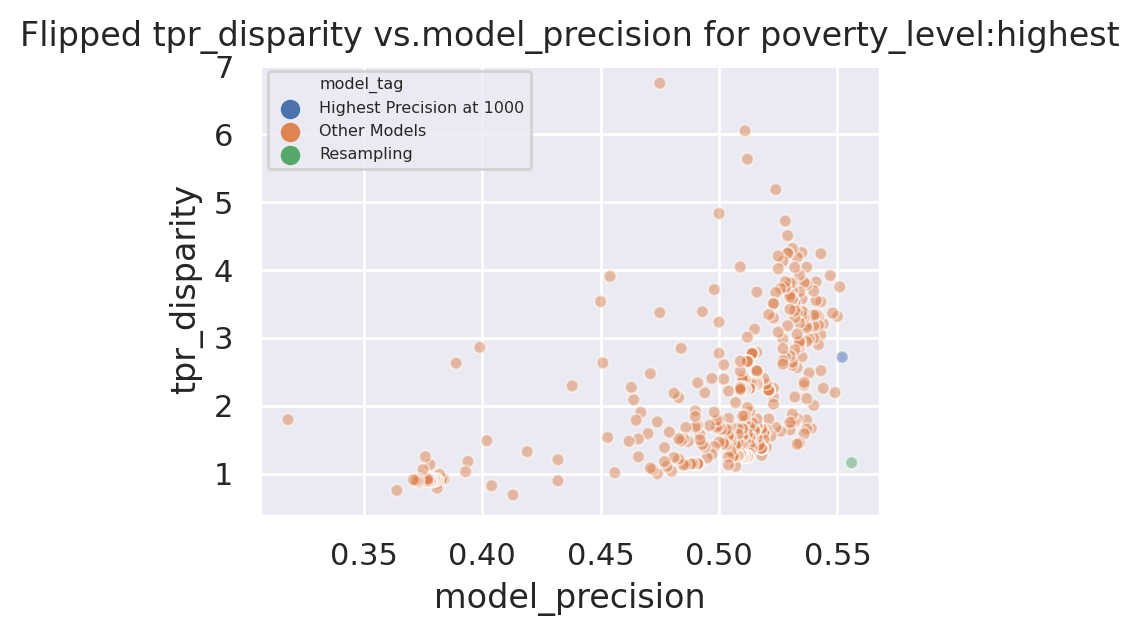

In [37]:
mitigated_precision = df.loc[df['score']==1]['label_value'].mean()
plot_configs = {
    'evals_df':evals_df, 
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tag':'Resampling',
    'mitigated_bdf':bdf, 
    'mitigated_performance':mitigated_precision, 
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)

## <font color=red>Bias Reduction Strategy 2: Regularization (using Fairlearn package)</font>
### <font color=red>In-Processing Fairness Improvement</font>

### 1. Install dependencies, import packages and data
This is needed every time you open this notebook in colab to install dependencies

In [38]:
# Let's use the methods 
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, TruePositiveRateDifference
from fairlearn.metrics import selection_rate_group_summary

### What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. We then used these results to pick a "best" model in terms of performance on the "accuracy" metric we care about: **Precision at the top 1000** (corresponding to our goal of selecting 1000 project submissions that are most likely to not get funded in order to prioritize resource allocation).

When we audited this selected model with Aequitas, however, we found biases across many attributes, including the poverty level of the schools. Here, we explore a method of using in-processing to train a fairness-aware classifier in order to reduce this bias.

### <font color=green>FairLearn - a reductions approach</font>

[Paper](https://arxiv.org/pdf/1803.02453.pdf): _A Reductions Approach to Fair Classification_, 2018

> We present a systematic approach for achievingfairness in a binary classification setting. Whilewe focus on two well-known quantitative defini-tions of fairness, our approach encompasses manyother  previously  studied  definitions  as  specialcases. The key idea is to __reduce fair classification__ to a __sequence  of  cost-sensitive__  classification problems, whose solutions yield a randomized classifier with the __lowest (empirical) error__ subject to  the  __desired  constraints__.   We  introduce  two reductions that work for any representation of the cost-sensitive  classifier  and  compare  favorably to prior baselines on a variety of data sets, while overcoming several of their disadvantages.

[FairLearn Documentation](https://fairlearn.github.io/user_guide/mitigation.html#id17)



### TLDR; 

- This approach poses Fair Learning as a constrained optimization problem: minimize the empirical error, subject to linear constraints of the fairness (e.g., TPR difference, demographic parity).
- Solve the constrained optimization as a __cost-sensitive__ classification problem.
- Obtain a __randomized classifier__, which implies they will create multiple base estimators.


### Load train and test matrices as well as protected attributes

In [39]:
traindf = pd.read_csv(DATAPATH + 'train_20120501_20120801.csv.gz', compression='gzip')
testdf = pd.read_csv(DATAPATH + 'test_20121201_20130201.csv.gz', compression='gzip')
train_attrdf = pd.read_csv(DATAPATH + 'train_20120501_20120801_protected.csv.gz', compression='gzip')
test_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

### Set up some parameters we'll need below and create matrices

In [40]:
label_col = 'quickstart_label'
date_col = 'as_of_date'
id_col = 'entity_id'
attr_col = 'poverty_level'
exclude_cols = [label_col, date_col, id_col]

top_k = 1000

# aequitas parameters
metrics = ['tpr']
disparity_threshold = 1.3
protected_attribute_ref_group = {attr_col:'lower'}


X_train, y_train, A_train = traindf[[c for c in traindf.columns if c not in exclude_cols]].values, traindf[label_col].values, train_attrdf[[attr_col]]
X_test,   y_test,   A_test   = testdf[[c for c in testdf.columns if c not in exclude_cols]].values,   testdf[label_col].values  , test_attrdf[[attr_col]]


### Setting up a fairness-improving classifier

To account fairness during model training, we'll use the **Exponentiated Gradient** provided by the `fairlearn` module.


Its hyperparameters are: 
- `estimator`: an estimator that implements the methods `fit(X, y, sample_weight)` and `predict(X)`.
- `constraints`: fairness constraints.
- `eps: float`: fairness threshold, i.e., how much constraint violation we support (defaults to 0.01). 
- `T: int`: maximum number of iterations (defaults to 50).
- `nu: float`: convergence threshold for duality gap (defaults to None).
- `eta_0: float`: initial learning rate (defaults to 2).
- `run_linprog_step: bool`: whether to apply saddle point optimization to the convex hull of classifiers obtained so far, after each exponentiated gradient step (defaults to True).

In [41]:
# NOTE: Exponentiated Gradient has a stoachastic component
np.random.seed(0)

Notice that we're using `TruePositiveRateDifference` for our fairness constraint here since we care about equalizing **recall** (aka **tpr** aka **equality of opportunity**) across our subgroups:

In [42]:
# Step 1. Define the constraint
constraint = TruePositiveRateDifference()

# Step 2. Define the base estimator (any estimator providing 'fit' and 'predict')
# Note: we could have used other algorithm such as logistic regression or random forest
base_estimator = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10)

# Step 3. Define the bias reducer algorithm you want to apply
bias_reducer = ExponentiatedGradient(base_estimator, constraint, T=50)

# Step 4. Fit the data (and provide the sensitive attributes)
bias_reducer.fit(X_train, y_train, sensitive_features=A_train)

### Predict on our test set

In [43]:
# Step 5. Use the mitigator to make predictions 
y_pred = bias_reducer.predict(X_test)
new_preds = testdf[['entity_id','as_of_date','quickstart_label']].copy()
new_preds['score'] = y_pred

### Look at the output
Notice that unlike many classifiers, the `ExponentiatedGradient` doesn't have a method for predicting a continuous score, just predicted classes of 0 or 1. How many projects did this model predict are at risk of going unfunded (that is, predicted class of 1)?

In [44]:
new_preds['score'].value_counts()

0    11128
1     6549
Name: score, dtype: int64

It looks like about 6,500 projects are predicted as being at risk of going unfunded by this classifier, but unfortunately our program is resource-constrained and can only help 1,000 of them. At this point, if we wanted to pick out the 1,000 highest-risk projects (subject to our fairness constraint), we're a bit stuck: **the classifier doesn't give us any method for distinguishing higher-risk vs lower-risk projects!**

Given this limitation, we might posit that a reasonable approach would be to pick 1,000 projects to intervene with from among these 6,500. Let's see what would happen if we did that...

### Before and After: Run Aequitas

For reference, let's start with looking at the "best" model we chose in terms of overall precision at 1,000:

#### Load the predictions from the "best" model chosen earlier

In [45]:
old_preds = pd.read_csv(DATAPATH + 'predictions_c598fbe93f4c218ac7d325fb478598f1.csv.gz', compression='gzip')
old_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

old_df = pd.merge(old_preds, old_attrdf, how='left', on=[id_col, date_col], left_index=True, right_index=False, sort=True, copy=True)

old_df = old_df.sort_values('predict_proba', ascending=False)
old_df = old_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
old_df['score'] = old_df.apply(lambda x: 1.0 if x.name in old_df.head(top_k).index.tolist() else 0, axis=1)

#### Before: Run Aequitas for the "best" model chosen earlier

In [46]:
g = Group()
b = Bias()

xtab_old, _ = g.get_crosstabs(old_df[['score', 'label_value', attr_col]].copy())
bdf_old = b.get_disparity_predefined_groups(xtab_old, original_df=old_df, ref_groups_dict=protected_attribute_ref_group)

ap.disparities_metrics(bdf_old, metrics, attr_col, fairness_threshold=disparity_threshold)

model_id, score_thresholds 0 {'rank_abs': [1000]}
get_disparity_predefined_group()


alt.HConcatChart(...)

#### After: Run Aequitas for the new, fairness-aware model

Remember here that we would choose 1,000 at random from the 6,500 with predicted class 1, so the expected value for the recall disparity of this randomly-selected set would just be the value of full set (that is, the recall of each subgroup would, on average, be proportionally lower in the sub-sample):

In [47]:
df = pd.merge(new_preds, test_attrdf, how='left', on=['entity_id','as_of_date'], left_index=True, right_index=False, sort=True, copy=True)
df = df.rename(columns = {label_col:'label_value'})

g = Group()
b = Bias()

xtab, _ = g.get_crosstabs(df[['score','label_value',attr_col]].copy())
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict=protected_attribute_ref_group)

ap.disparities(bdf, metrics, attr_col, fairness_threshold=disparity_threshold)

model_id, score_thresholds 0 {'rank_abs': [6549]}
get_disparity_predefined_group()


alt.LayerChart(...)

That looks pretty good! The new model appears to have reduced the disparity across poverty levels considerably relative to what we saw when training a model without a fairness constraint and choosing based on precision alone.

However, the natural question here is where there is a fairness-accuracy trade-off here: What cost did we incur in terms of model performance, that is overall precision?

#### Precision of the "best" model chosen earlier

In [48]:
old_df.loc[old_df['score']==1]['label_value'].mean()

0.552

#### Precision of the new, fairness-aware model

As above, we would be sampling from the 6,500 down to 1,000 but the expected value of precision in this sample would just be the mean label value in the full population:

In [49]:
df.loc[df['score']==1]['label_value'].mean()

0.4083066116964422

So, compared to the old model, this method has resulted in **quite a large trade-off in model performance to acheive fairness**. This is certainly in part a result of the lack of flexibility in the method not allowing us to provide a score threshold or top k size that we're interested in equalizing our fairness metric around and instead using a built-in threshold that yields 6,500 predicted positives when we're only able to intervene on 1,000. Unfortunately, this sort of inflexibility appears to be a common attribute of many in-processing methods available today.

For context, the overall base rate (`df['label_value'].mean()`) is 0.338, so the drop-off in precision here is about half way from our previous model to simply choosing at random.

### Adding to model selection

Finally, let's look at how this new option stacks up against what we plotted in our model selection process:

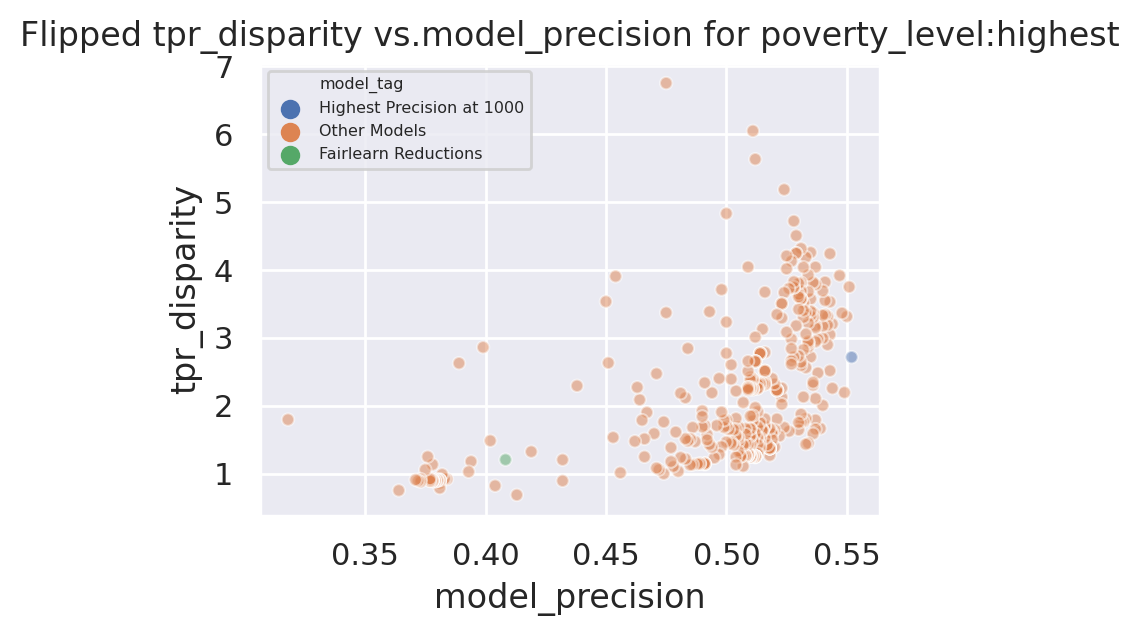

In [50]:
mitigated_precision = df.loc[df['score']==1]['label_value'].mean()
plot_configs = {
    'evals_df':evals_df, 
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tag':'Fairlearn Reductions',
    'mitigated_bdf':bdf, 
    'mitigated_performance':mitigated_precision, 
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)

## <font color=red>Bias Reduction Strategy 3: Post-Hoc Disparity Mitigation</font>

### What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. We then used these results to pick a "best" model in terms of performance on the "accuracy" metric we care about: **Precision at the top 1000** (corresponding to our goal of selecting 1000 project submissions that are most likely to not get funded in order to prioritize resource allocation).

When we audited this selected model with Aequitas, however, we found biases across many attributes, including the poverty level of the schools. Here, we explore a method of using post-hoc disparity mitigation to reduce this bias in the selected model.

### <font color=green>Intro to Post-Hoc Bias Mitigation</font>

![Diagram of Post-Hoc Adjustments](post_hoc_adj.png "Post-Hoc Adjustments")

One approach to improving the fairness of our model is to make post-hoc adjustments to the thresholds used for each subgroup to choose the 1,000 projects on which to intervene. Because our fairness metric here (**recall** aka **tpr** aka **equality of opportunity**) is monatonically increasing with the depth of the score, we should be able to find score thresholds for each subgroup that will equalize this metric across the groups, subject to the constraint that we want to choose a total of 1,000 projects for our intervation.

In short, here's how this will work (see the references below for a more detailed discussion):
1. Train the model as usual on a training set, predict scores on a test set
2. Split this test set by subgroups on our protected attribute (here, poverty level)
3. Sort each subgroup by score and calculate the cumulative tpr/recall up to and including each row in the set, storing this "rolling within-subgroup recall" value
4. Recombine the subgroups, and sort the entire set by this new value
5. Take the top 1,000 projects from this re-ordered list and use it to calculate "top k" sizes for each subgroup that equalize recall
6. Then, on a future test set, use these calculated subgroup list sizes to assess the impact of disparities and overall precision

References:
- Hardt, et al, [Equality of Opportunity in Supervised Learning](http://papers.nips.cc/paper/6373-equality-of-opportunity-in-supervised-learning)
- Rodolfa, et al, [Case Study: Predictive Fairness to Reduce Misdemeanor Recidivism Through Social Service Interventions](https://dl.acm.org/doi/abs/10.1145/3351095.3372863?casa_token=zc196JJrqkkAAAAA:bPmqmKrA91esJhIxHPT4K1crWWb5JGcflVFDkTgODctMzLpUX50_56Kyyh4NJ2GTd_QSydqhNpjT)

### Load the train, test, and protected attributes from the first split

In [51]:
split1_traindf = pd.read_csv(DATAPATH + 'train_20111101_20120201.csv.gz', compression='gzip')
split1_testdf = pd.read_csv(DATAPATH + 'test_20120601_20120801.csv.gz', compression='gzip')
split1_attrdf = pd.read_csv(DATAPATH + 'test_20120601_20120801_protected.csv.gz', compression='gzip')

Let's just take a quick look at the data to make sure it makes sense:

In [52]:
split1_traindf.head()

,entity_id,as_of_date,project_features_entity_id_all_grade_level_Grades35_sum,project_features_entity_id_all_grade_level_Grades68_sum,project_features_entity_id_all_grade_level_Grades912_sum,project_features_entity_id_all_grade_level_GradesPreK2_sum,project_features_entity_id_all_grade_level__NULL_sum,project_features_entity_id_all_resource_type_Books_sum,project_features_entity_id_all_resource_type_Other_sum,project_features_entity_id_all_resource_type_Supplies_sum,project_features_entity_id_all_resource_type_Technology_sum,project_features_entity_id_all_resource_type_Trips_sum,project_features_entity_id_all_resource_type_Visitors_sum,project_features_entity_id_all_resource_type__NULL_sum,project_features_entity_id_all_school_metro__NULL_sum,project_features_entity_id_all_school_metro_rural_sum,project_features_entity_id_all_school_metro_suburban_sum,project_features_entity_id_all_school_metro_urban_sum,project_features_entity_id_all_school_state_AK_sum,project_features_entity_id_all_school_state_AL_sum,project_features_entity_id_all_school_state_AR_sum,project_features_entity_id_all_school_state_AZ_sum,project_features_entity_id_all_school_state_CA_sum,project_features_entity_id_all_school_state_CO_sum,project_features_entity_id_all_school_state_CT_sum,project_features_entity_id_all_school_state_DC_sum,project_features_entity_id_all_school_state_DE_sum,project_features_entity_id_all_school_state_FL_sum,project_features_entity_id_all_school_state_GA_sum,project_features_entity_id_all_school_state_HI_sum,project_features_entity_id_all_school_state_IA_sum,project_features_entity_id_all_school_state_ID_sum,project_features_entity_id_all_school_state_IL_sum,project_features_entity_id_all_school_state_IN_sum,project_features_entity_id_all_school_state_KS_sum,project_features_entity_id_all_school_state_KY_sum,project_features_entity_id_all_school_state_LA_sum,project_features_entity_id_all_school_state_La_sum,project_features_entity_id_all_school_state_MA_sum,project_features_entity_id_all_school_state_MD_sum,...,project_features_entity_id_all_teacher_prefix_Mr_sum,project_features_entity_id_all_teacher_prefix_Mrs_sum,project_features_entity_id_all_teacher_prefix_Ms_sum,project_features_entity_id_all_teacher_prefix__NULL_sum,project_features_entity_id_all_teacher_prefix__sum,project_features_entity_id_all_total_asking_price_sum,project_features_entity_id_all_total_asking_price_imp,resources_features_entity_id_all_item_quantity_sum,resources_features_entity_id_all_item_quantity_imp,essay_features_entity_id_all_lengthessayint_sum,essay_features_entity_id_all_lengthessayint_imp,donation_features_entity_id_all_district_avg_donations_1yr_sum,donation_features_entity_id_all_district_avg_donations_1yr_imp,donation_features_entity_id_all_district_avg_donations_2yr_sum,donation_features_entity_id_all_district_avg_donations_2yr_imp,donation_features_entity_id_all_district_funding_rate_1yr_sum,donation_features_entity_id_all_district_funding_rate_1yr_imp,donation_features_entity_id_all_district_funding_rate_2yr_sum,donation_features_entity_id_all_district_funding_rate_2yr_imp,donation_features_entity_id_all_teacher_avg_donations_1yr_sum,donation_features_entity_id_all_teacher_avg_donations_1yr_imp,donation_features_entity_id_all_teacher_avg_donations_2yr_sum,donation_features_entity_id_all_teacher_avg_donations_2yr_imp,donation_features_entity_id_all_teacher_funding_rate_1yr_sum,donation_features_entity_id_all_teacher_funding_rate_1yr_imp,donation_features_entity_id_all_teacher_funding_rate_2yr_sum,donation_features_entity_id_all_teacher_funding_rate_2yr_imp,donation_features_entity_id_all_zip_avg_donations_1yr_sum,donation_features_entity_id_all_zip_avg_donations_1yr_imp,donation_features_entity_id_all_zip_avg_donations_2yr_sum,donation_features_entity_id_all_zip_avg_donations_2yr_imp,donation_features_entity_id_all_zip_funding_rate_1yr_sum,donation_features_entity_id_all_zip_funding_rate_1yr_imp,donation_features_entity_id_all_zip_funding_r

### Set up some parameters we'll need below

Note that the classifier type and hyperparameters here are from the best-performing model we chose above based on precision on the top 1000.

In [54]:
hyperparameters = {
    'criterion': 'gini',
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 44,
    'min_samples_split': 3,
    'n_estimators': 87,
    'n_jobs': -1,
    'random_state': 213500298
}
clf = RandomForestClassifier(**hyperparameters)

top_k = 1000

label_col = 'quickstart_label'
entity_col = 'entity_id'
date_col = 'as_of_date'
exclude_cols = [label_col, entity_col, date_col] # columns to exclude from the X matrices for the classifier

protected_attribute_col = 'poverty_level'

# Parameters for Aequitas

metrics = ['tpr']
disparity_threshold = 1.3
protected_attribute_ref_group = {protected_attribute_col:'lower'}


### Train the model and predict on the test set

In [55]:
# train
y_train = split1_traindf[label_col].values
clf.fit(split1_traindf.drop(exclude_cols, axis = 1), y_train)

# test set predictions
split1_preds = split1_testdf[[entity_col, date_col, label_col]].copy()
split1_preds['predict_proba'] = clf.predict_proba(split1_testdf.drop(exclude_cols, axis = 1))[:,1]

Let's take a quick look at the predictions to make sure they look good:

In [56]:
split1_preds.head()

,entity_id,as_of_date,quickstart_label,predict_proba
0,246363,1338591600000,1.0,0.382485
1,246362,1338591600000,1.0,0.188013
2,246361,1338591600000,0.0,0.398983
3,246360,1338591600000,0.0,0.422042
4,246359,1338591600000,1.0,0.403111


### Combine predictions with protected attributes

In [57]:
df = pd.merge(split1_preds, split1_attrdf, how='left', on=[entity_col,date_col], left_index=True, right_index=False, sort=True, copy=True)

### Sort by score, then split by protected attribute (poverty level)

In [58]:
protected_attribute_groups = df[protected_attribute_col].unique()

In [59]:
df = df.sort_values('predict_proba', ascending=False)
subgroup_dfs = []
for grp in protected_attribute_groups:
    subgroup_dfs.append(df[df[protected_attribute_col]==grp].copy())

### Calculate within-subgroup cumulative recall

Here, we calculate the recall up to and including each row within the highest-poverty and lower-poverty subsets of the test set. Doing this allows us to recombine and sort the sets in a way that will let find recall-equalizing "top k" list sizes for each subgroup.

In [60]:
for subgrp_df in subgroup_dfs:
    subgrp_df['cumsum_recall'] = subgrp_df[label_col].cumsum() / subgrp_df[label_col].sum()

### Recombine the subgroup sets and sort by this cumulative recall

In [61]:
recall_df = pd.concat(subgroup_dfs, axis=0).sort_values('cumsum_recall', ascending=True)

### Find subgroup sizes, holding the overall list size (1000) constant

Now we can simply threshold this re-sorted list by `top_k` (here, 1000) to identify how many individuals from each group we should apply in the future.

Notice here that each subgroup will still be ordered by their predicted score, but the scores will no longer be perfectly ordered across subgroups.

In [62]:
new_pp = recall_df.head(top_k).copy()
new_pp.tail()

,entity_id,as_of_date,quickstart_label,predict_proba,poverty_level,teacher_sex,metro_type,cumsum_recall
9401,236962,1343343600000,0.0,0.423424,highest,female,urban,0.137341
9809,236827,1343430000000,1.0,0.470249,lower,female,suburban_rural,0.137405
4857,241717,1341183600000,1.0,0.423386,highest,female,suburban_rural,0.137780
1610,245042,1339455600000,0.0,0.470204,lower,female,suburban_rural,0.137882
10611,236358,1343516400000,1.0,0.470228,lower,female,suburban_rural,0.137882


In [63]:
new_pp[protected_attribute_col].value_counts()

highest    554
lower      446
Name: poverty_level, dtype: int64

Let's just store this to re-use below:

In [64]:
subgroup_k = {} 
for grp in protected_attribute_groups:
  subgroup_k[grp] = new_pp[protected_attribute_col].value_counts()[grp]

### Apply these subgroup-specific sizes to future test set data

Now we have calculated the number of projects we need to select from each poverty level, we can apply these to the most recent split to assess how well this method reduces the recall disparities we saw initially and whether this has any impact on the overall precision of the model.

### Load the predictions and protected attributes from the future test set

Note that the predictions here correspond to the same model + hyperparameters we specified above

In [65]:
split2_preds = pd.read_csv(DATAPATH + 'predictions_c598fbe93f4c218ac7d325fb478598f1.csv.gz', compression='gzip')
split2_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

df2 = pd.merge(split2_preds, split2_attrdf, how='left', on=[entity_col, date_col], left_index=True, right_index=False, sort=True, copy=True)

Take a quick look to make sure the data loaded without any issue:

In [66]:
df2.head()

,entity_id,as_of_date,quickstart_label,predict_proba,poverty_level,teacher_sex,metro_type
17310,119,1359504000000,0.0,0.364484,lower,female,suburban_rural
15801,120,1359158400000,0.0,0.347160,highest,female,unknown
14694,121,1358812800000,1.0,0.503259,lower,female,suburban_rural
14226,122,1358726400000,0.0,0.442060,lower,female,unknown
14227,123,1358726400000,0.0,0.325577,lower,female,urban


### Split the test set by poverty level to apply the thresholds

In [67]:
df2 = df2.sort_values('predict_proba', ascending=False)
new_subgroup_dfs = {}
for grp in protected_attribute_groups:
    new_subgroup_dfs[grp] = df2[df2[protected_attribute_col]==grp].copy()

### Choose the number of projects from each subgroup found above

Notice here that we're choosing the "top k" individuals within each subgroup based on their predicted score -- in a deployment, we wouldn't know the true labels to calculate recall values, which is why we had to go one step back in time to find these group sizes.

In [68]:
pp_dfs = []
for grp in protected_attribute_groups:
    pp_dfs.append(new_subgroup_dfs[grp].head(subgroup_k[grp]))

### Recombine and create a predicted class label for this resulting set
That is, 1,000 projects with a label 1 chosen by this process and 0 otherwise

In [69]:
new_pp2 = pd.concat(pp_dfs, axis=0).sort_values('predict_proba', ascending=True)

mitigated_df = df2.copy()
mitigated_df = mitigated_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
mitigated_df['score'] = mitigated_df.apply(lambda x: 1.0 if x.name in new_pp2.index.tolist() else 0, axis=1)

for comparison, let's also look at the unmitigated result again...

In [70]:
unadjusted_df = df2.sort_values('predict_proba', ascending=False).copy()
unadjusted_df = unadjusted_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
unadjusted_df['score'] = unadjusted_df.apply(lambda x: 1.0 if x.name in unadjusted_df.head(top_k).index.tolist() else 0, axis=1)

### Running Aequitas - Before and After

#### For the original score, without post-hoc adjustment for equity

In [71]:
g = Group()
b = Bias()

xtab_unadjusted, _ = g.get_crosstabs(unadjusted_df[['score', 'label_value', protected_attribute_col]].copy())
bdf_unadjusted = b.get_disparity_predefined_groups(xtab_unadjusted, original_df=unadjusted_df, ref_groups_dict=protected_attribute_ref_group)

ap.disparities_metrics(bdf_unadjusted, metrics, protected_attribute_col, fairness_threshold=disparity_threshold)

model_id, score_thresholds 0 {'rank_abs': [1000]}
get_disparity_predefined_group()


alt.HConcatChart(...)

#### For the score, with post-hoc disparity mitigation

In [72]:
g = Group()
b = Bias()

xtab_mitigated, _ = g.get_crosstabs(mitigated_df[['score', 'label_value', protected_attribute_col]].copy())
bdf_mitigated = b.get_disparity_predefined_groups(xtab_mitigated, original_df=mitigated_df, ref_groups_dict=protected_attribute_ref_group)

ap.disparities_metrics(bdf_mitigated, metrics, protected_attribute_col, fairness_threshold=disparity_threshold)

model_id, score_thresholds 0 {'rank_abs': [1000]}
get_disparity_predefined_group()


alt.HConcatChart(...)

So, it looks the post-hoc adjustments have actually manage to mitigate the existing disparity pretty well (perhaps even over-shooting somewhat, though still within our fairness threshold of 1.3).

However, the natural question here is where there is a fairness-accuracy trade-off here: What cost did we incur in terms of model performance, that is overall precision?

#### Before: Precision of the original, unadjusted score

In [73]:
unadjusted_df.loc[unadjusted_df['score']==1]['label_value'].mean()

0.552

#### After: Precision of the new, disparity-mitigated score

In [74]:
mitigated_df.loc[mitigated_df['score']==1]['label_value'].mean()

0.581

Somewhat surprisingly, we actually don't seem to see any trade-off with the disparity mitigation here!

### Adding to the model selection (tradeoff) graph

Finally, let's look at how this new option stacks up against what we plotted in our model selection process:

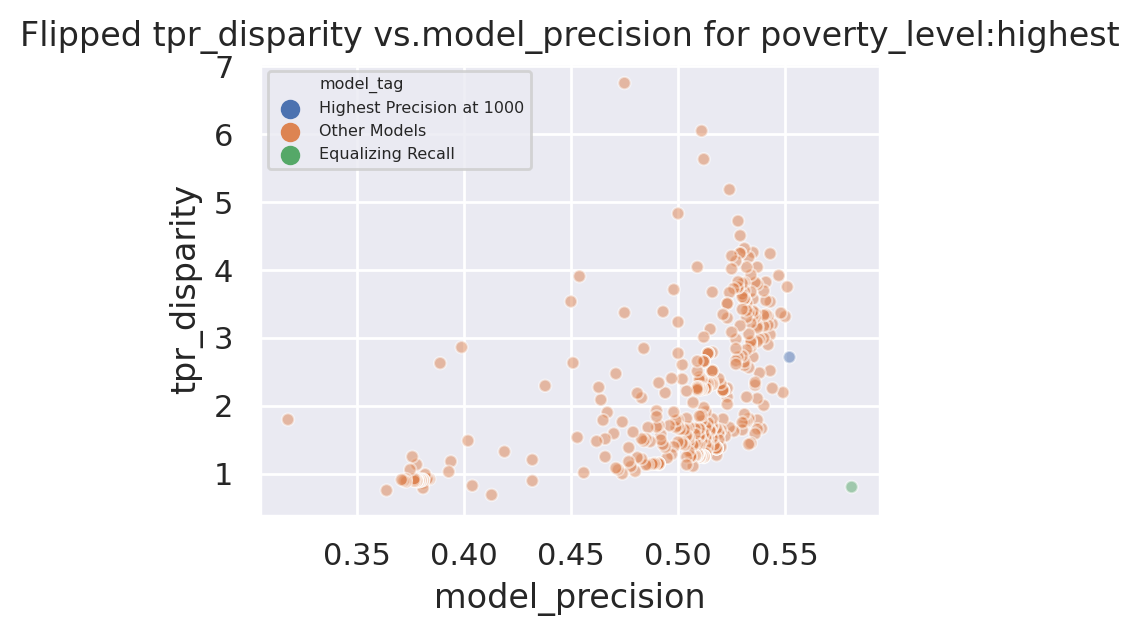

In [75]:
mitigated_precision = mitigated_df.loc[mitigated_df['score']==1]['label_value'].mean()
plot_configs = {
    'evals_df':evals_df, 
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tag':'Equalizing Recall',
    'mitigated_bdf':bdf_mitigated, 
    'mitigated_performance':mitigated_precision, 
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)